Import Libraries

In [1]:
from PIL import Image
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

Importing Images Function

In [2]:
# Paths to the training and test data
train_dir = r'C:\Users\محمد عبدالفتاح\Desktop\Alzheimers-disease\3- Final\Alzheimers-ADNI\train'
test_dir = r'C:\Users\محمد عبدالفتاح\Desktop\Alzheimers-disease\3- Final\Alzheimers-ADNI\test'

# Image parameter (size)
img_size = (256, 256)

# Function to load and preprocess images
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize(img_size)
                img = np.array(img)
                images.append(img)
                labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

Noise Functions

In [3]:
# Add Gaussian Noise
def add_gaussian_noise(images, mean=0, std=10):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, std, img.shape).astype(np.float32)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, 0, 255)
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

# Add Salt-and-Pepper Noise
def add_salt_and_pepper_noise(images, amount=0.01):
    noisy_images = []
    for img in images:
        noisy_img = img.copy()
        num_salt = np.ceil(amount * img.size * 0.5)
        num_pepper = np.ceil(amount * img.size * 0.5)

        # Add salt noise
        coords = [
            np.random.randint(0, max(i - 1, 1), int(num_salt)) for i in img.shape
        ]
        noisy_img[coords[0], coords[1]] = 255
        # Add pepper noise
        coords = [
            np.random.randint(0, max(i - 1, 1), int(num_pepper)) for i in img.shape
        ]
        noisy_img[coords[0], coords[1]] = 0

        noisy_images.append(noisy_img)
    return np.array(noisy_images)

Filter Functions

In [4]:
def apply_bilateral_filter(images):
    filtered_images = []
    for img in images:
        filtered_img = cv2.bilateralFilter(img.astype(np.uint8), d=9, sigmaColor=75, sigmaSpace=75)
        filtered_images.append(filtered_img)
    return np.array(filtered_images)

def apply_median_filter(images):
    filtered_images = []
    for img in images:
        filtered_img = cv2.medianBlur(img.astype(np.uint8), ksize=5)
        filtered_images.append(filtered_img)
    return np.array(filtered_images)

def apply_gaussian_filter(images):
    filtered_images = []
    for img in images:
        filtered_img = cv2.GaussianBlur(img.astype(np.uint8), (5, 5), 10)
        filtered_images.append(filtered_img)
    return np.array(filtered_images)

def unsharp_mask(image, sigma=1.0, strength=1):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    kernel_size = int(6 * sigma + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

def median_Gaussian_filters(images):
    denoised_images = []
    for img in images:
        img = cv2.medianBlur(img.astype(np.uint8), 3)
        img = cv2.GaussianBlur(img, (5, 5), 10)
        denoised_images.append(img)
    return np.array(denoised_images)

Preparing train & test images

In [5]:
# Load training and testing data
X_train, y_train = load_images_from_directory(train_dir)


#Add noisy imagws
num_samples = len(X_train)
noise_samples = num_samples // 3
indices_noisy = np.random.choice(num_samples, noise_samples, replace=False)

noisy_Images = X_train[indices_noisy]
y_train_noisy = y_train[indices_noisy]

X_train_noisy = add_gaussian_noise(noisy_Images)
X_train_noisy = add_salt_and_pepper_noise(X_train_noisy)

#Add enhancement images (after filtering the noisy images)
X_train_enhancement = median_Gaussian_filters(X_train_noisy)
X_train_enhancement = unsharp_mask(X_train_enhancement)

#Concat origin & noisy & enhanced images and labels
X_train = np.concatenate((X_train_noisy, X_train, X_train_enhancement), axis=0)
y_train = np.concatenate((y_train_noisy, y_train, y_train_noisy), axis=0)


#Over sampling because MCI class has 1:10 images compared to other classes
X_train_flat = X_train.reshape(len(X_train), -1)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_flat, y_train)
X_train = X_train.reshape(-1, *X_train.shape[1:])

#Shuffle to prevent pattern learning (or over fitting will be causes)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

#Load testing images
X_test, y_test = load_images_from_directory(test_dir)
x_testCopy = np.copy(X_test) #we will need this copy later

# Encode labels (AD, MCI, NC) into integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Scaling the data and Applying PCA techniques (for better performance)

In [6]:
#First let's flatten the images before using Scaler
n_samples = X_train.shape[0]
X_train_flattened = X_train.reshape(n_samples, -1).astype(np.float32)  # Flatten each image to a vector


#Scale the data for PCA, SVM (or maybe underfitting occures)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)

Preparing the test images

In [7]:
#First let's flatten the images before using Scaler
n_samples = X_test.shape[0]
X_test_flattened = X_test.reshape(n_samples, -1).astype(np.float32)  # Flatten each image to a vector


#Scale the data for PCA, SVM (or maybe underfitting occures)
X_test_scaled = scaler.transform(X_test_flattened)

X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

Apply PCA for dimension reduction and feature extraction

In [13]:
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Apply SVM model using ensamble learning and test the results

In [14]:
svc_model = SVC(C=100, gamma='scale', kernel='rbf')
bagging = BaggingClassifier(estimator=svc_model, n_estimators=5, n_jobs=-1)
bagging.fit(X_train_pca, y_train)
y_pred_bagging = bagging.predict(X_test_pca)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging) * 100
print(f"Accuracy : {accuracy_bagging:.4f}")

Accuracy : 97.6138


Display Classification report & confusion matrix

In [15]:
#Now let's see the classification report to know more about classification results
class_report = classification_report(y_test, y_pred_bagging, target_names=['AD', 'MCI', 'NC'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          AD       0.98      0.98      0.98       810
         MCI       0.89      1.00      0.94       233
          NC       0.99      0.97      0.98      1220

    accuracy                           0.98      2263
   macro avg       0.95      0.98      0.97      2263
weighted avg       0.98      0.98      0.98      2263



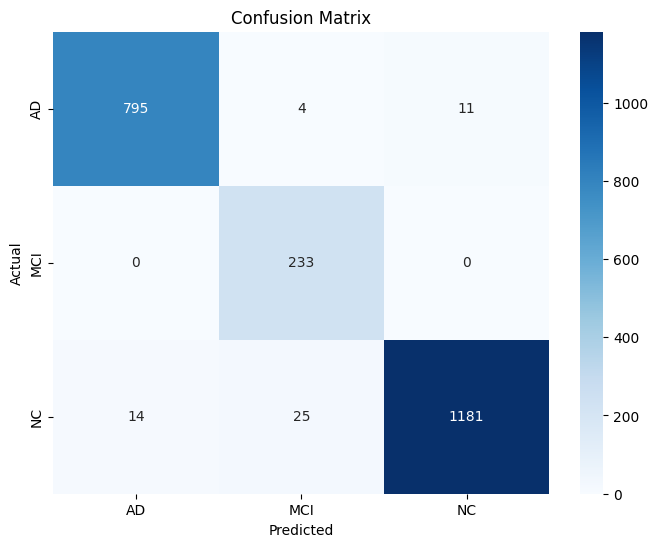

In [16]:
#Now let's show the confusion matrix.
cm = confusion_matrix(y_test, y_pred_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'MCI', 'NC'], yticklabels=['AD', 'MCI', 'NC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#Comments: 98% accuracy of Alzheimer’s Disease detection (That's exactly what we want, we prefered to detect the person who have disease 98% accuracy over than detect normal person 95% accuracy).
#Let's try other models as RandomForest and CNN"

Apply Noises Filters on test images

In [17]:
# Generate Noisy Images
gaussian_noisy_images = add_gaussian_noise(x_testCopy)
salt_pepper_noisy_gaussian_images = add_salt_and_pepper_noise(gaussian_noisy_images)

Test Noisy Images

In [18]:
#apply pca
n_samples = salt_pepper_noisy_gaussian_images.shape[0]
X_test_flattened = salt_pepper_noisy_gaussian_images.reshape(n_samples, -1).astype(np.float32)  # Flatten each image to a vector
X_test_scaled = scaler.transform(X_test_flattened)
X_test_pca = pca.transform(X_test_scaled)

In [19]:
y_pred_bagging = bagging.predict(X_test_pca)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging) * 100
print(f"Accuracy : {accuracy_bagging:.4f}")

Accuracy : 94.2554


In [21]:
#Now let's see the classification report to know more about classification results
class_report = classification_report(y_test, y_pred_bagging, target_names=['AD', 'MCI', 'NC'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          AD       0.95      0.96      0.96       810
         MCI       0.84      0.81      0.83       233
          NC       0.95      0.96      0.96      1220

    accuracy                           0.94      2263
   macro avg       0.92      0.91      0.91      2263
weighted avg       0.94      0.94      0.94      2263



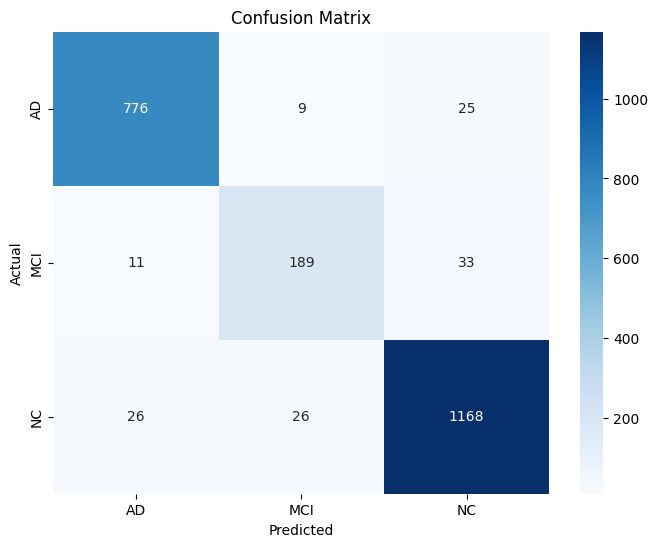

In [22]:
#Now let's show the confusion matrix.
cm = confusion_matrix(y_test, y_pred_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'MCI', 'NC'], yticklabels=['AD', 'MCI', 'NC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#Comments: 98% accuracy of Alzheimer’s Disease detection (That's exactly what we want, we prefered to detect the person who have disease 98% accuracy over than detect normal person 95% accuracy).
#Let's try other models as RandomForest and CNN"

Apply image enhancement and restortion:
    
    1- Bilateral Filter
    2- Median Filter
    3- Gaussian Filter
    4- Unsharp mask

enhanced_Image - PSNR: 26.65, SSIM: 0.78


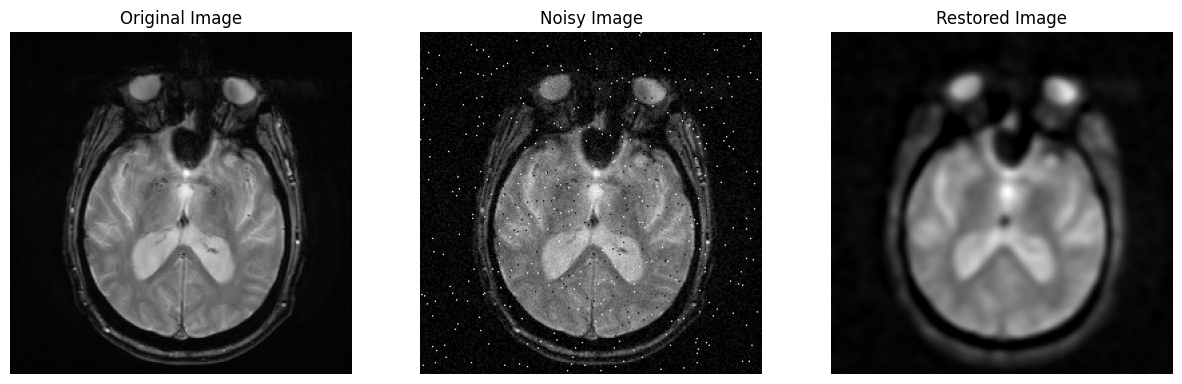

In [23]:

# Evaluate performance
def evaluate_performance(original, filtered):
    psnr_values = [psnr(original[i], filtered[i], data_range=255) for i in range(len(original))]
    ssim_values = [
        ssim(original[i], filtered[i], data_range=255) for i in range(len(original))
    ]
    return np.mean(psnr_values), np.mean(ssim_values)


#Apply filters
enhanced_Images = apply_median_filter(salt_pepper_noisy_gaussian_images)
enhanced_Images = apply_bilateral_filter(enhanced_Images)
enhanced_Images = apply_gaussian_filter(enhanced_Images)
#Evaluate and print Result
enhanced_psnr, enhanced_ssim = evaluate_performance(x_testCopy, enhanced_Images)
print(f"enhanced_Image - PSNR: {enhanced_psnr:.2f}, SSIM: {enhanced_ssim:.2f}")

#Apply unsharp mask
enhanced_Images = unsharp_mask(enhanced_Images)

#Print original vs noisy vs restored image sample
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_testCopy[1], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(salt_pepper_noisy_gaussian_images[1], cmap='gray')
plt.title("Noisy Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(enhanced_Images[1], cmap='gray')
plt.title("Restored Image")
plt.axis('off')
plt.show()


Prepare Restored Test Images

In [24]:
#apply pca
n_samples = enhanced_Images.shape[0]
X_test_flattened = enhanced_Images.reshape(n_samples, -1).astype(np.float32)  # Flatten each image to a vector
X_test_scaled = scaler.transform(X_test_flattened)
X_test_pca = pca.transform(X_test_scaled)

Now lets use these restored images on SVM model

In [25]:
y_pred_bagging = bagging.predict(X_test_pca)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging) * 100

print(f"Accuracy : {accuracy_bagging:.4f}")

Accuracy : 93.7251


In [26]:
#Now let's see the classification report to know more about classification results
class_report = classification_report(y_test, y_pred_bagging, target_names=['AD', 'MCI', 'NC'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          AD       0.95      0.94      0.95       810
         MCI       0.81      0.91      0.86       233
          NC       0.96      0.94      0.95      1220

    accuracy                           0.94      2263
   macro avg       0.91      0.93      0.92      2263
weighted avg       0.94      0.94      0.94      2263



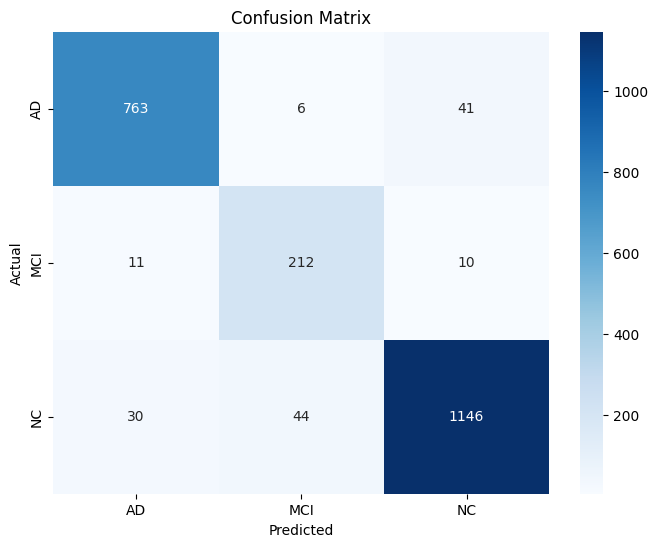

In [28]:
#Now let's show the confusion matrix.
cm = confusion_matrix(y_test, y_pred_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'MCI', 'NC'], yticklabels=['AD', 'MCI', 'NC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#Comments: 98% accuracy of Alzheimer’s Disease detection (That's exactly what we want, we prefered to detect the person who have disease 98% accuracy over than detect normal person 95% accuracy).
#Let's try other models as RandomForest and CNN"

Apply only median, gaussian and unshap mask filters

In [29]:
def denoise_images(images):
    denoised_images = []
    for img in images:
        img = cv2.medianBlur(img.astype(np.uint8), 3)
        img = cv2.GaussianBlur(img, (5, 5), 10)
        denoised_images.append(img)
    return np.array(denoised_images)

In [30]:
def unsharp_mask(image, sigma=1.0, strength=1):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    kernel_size = int(6 * sigma + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened


enhanced_Image - PSNR: 24.82, SSIM: 0.76


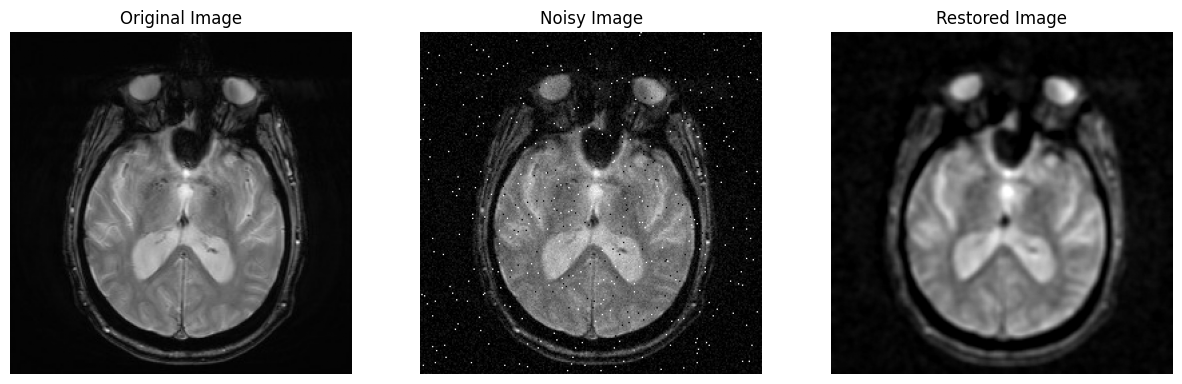

In [31]:
#Apply filters
enhanced_Images = denoise_images(salt_pepper_noisy_gaussian_images)
enhanced_Images = unsharp_mask(enhanced_Images)

#Evaluate and print Result
enhanced_psnr, enhanced_ssim = evaluate_performance(x_testCopy, enhanced_Images)
print(f"enhanced_Image - PSNR: {enhanced_psnr:.2f}, SSIM: {enhanced_ssim:.2f}")

#Apply unsharp mask

#Print original vs noisy vs restored image sample
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_testCopy[1], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(salt_pepper_noisy_gaussian_images[1], cmap='gray')
plt.title("Noisy Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(enhanced_Images[1], cmap='gray')
plt.title("Restored Image")
plt.axis('off')
plt.show()

In [32]:
#apply pca
n_samples = enhanced_Images.shape[0]
X_test_flattened = enhanced_Images.reshape(n_samples, -1).astype(np.float32)  # Flatten each image to a vector
X_test_scaled = scaler.transform(X_test_flattened)
X_test_pca = pca.transform(X_test_scaled)

In [34]:
y_pred_bagging = bagging.predict(X_test_pca)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging) * 100

print(f"Accuracy : {accuracy_bagging:.4f}")

Accuracy : 96.1555


In [35]:
#Now let's see the classification report to know more about classification results
class_report = classification_report(y_test, y_pred_bagging, target_names=['AD', 'MCI', 'NC'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          AD       0.97      0.97      0.97       810
         MCI       0.87      0.94      0.90       233
          NC       0.98      0.96      0.97      1220

    accuracy                           0.96      2263
   macro avg       0.94      0.96      0.95      2263
weighted avg       0.96      0.96      0.96      2263



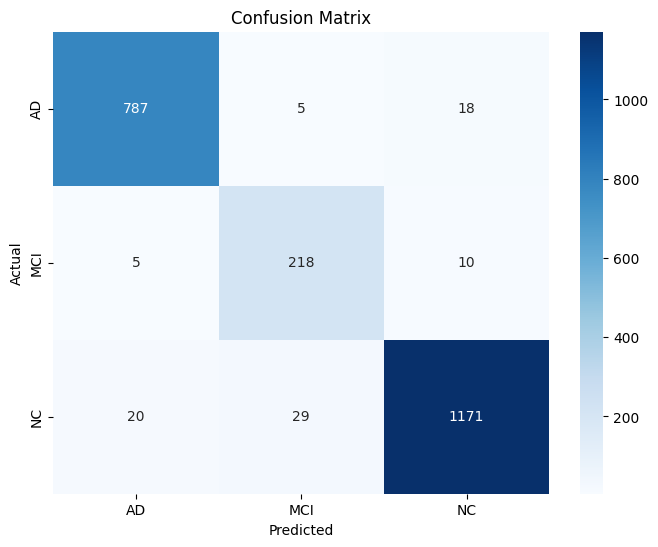

In [36]:
#Now let's show the confusion matrix.
cm = confusion_matrix(y_test, y_pred_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'MCI', 'NC'], yticklabels=['AD', 'MCI', 'NC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#Comments: 98% accuracy of Alzheimer’s Disease detection (That's exactly what we want, we prefered to detect the person who have disease 98% accuracy over than detect normal person 95% accuracy).
#Let's try other models as RandomForest and CNN"

Test the same filter but with increasing the noise rate to check svm stablility

In [40]:
# Add Gaussian Noise
def add_gaussian_noise(images, mean=0, std=20):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, std, img.shape).astype(np.float32)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, 0, 255)
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

# Add Salt-and-Pepper Noise
def add_salt_and_pepper_noise(images, amount=0.1):
    noisy_images = []
    for img in images:
        noisy_img = img.copy()
        num_salt = np.ceil(amount * img.size * 0.5)
        num_pepper = np.ceil(amount * img.size * 0.5)

        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
        noisy_img[coords[0], coords[1]] = 255

        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
        noisy_img[coords[0], coords[1]] = 0

        noisy_images.append(noisy_img)
    return np.array(noisy_images)


enhanced_Image - PSNR: 24.26, SSIM: 0.62


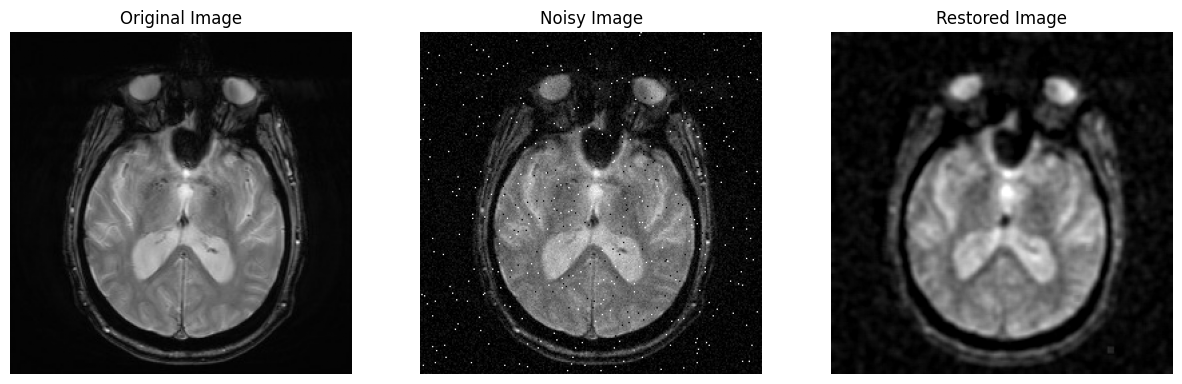

In [41]:
noisy = add_gaussian_noise(x_testCopy)
noisy = add_salt_and_pepper_noise(noisy)
enhanced_Images = denoise_images(noisy)
enhanced_Images = unsharp_mask(enhanced_Images)

#Evaluate and print Result
enhanced_psnr, enhanced_ssim = evaluate_performance(x_testCopy, enhanced_Images)
print(f"enhanced_Image - PSNR: {enhanced_psnr:.2f}, SSIM: {enhanced_ssim:.2f}")

#Apply unsharp mask

#Print original vs noisy vs restored image sample
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_testCopy[1], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(salt_pepper_noisy_gaussian_images[1], cmap='gray')
plt.title("Noisy Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(enhanced_Images[1], cmap='gray')
plt.title("Restored Image")
plt.axis('off')
plt.show()

In [42]:
#apply pca
n_samples = enhanced_Images.shape[0]
X_test_flattened = enhanced_Images.reshape(n_samples, -1).astype(np.float32)  # Flatten each image to a vector
X_test_scaled = scaler.transform(X_test_flattened)
X_test_pca = pca.transform(X_test_scaled)

In [43]:
y_pred_bagging = bagging.predict(X_test_pca)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging) * 100

print(f"Accuracy : {accuracy_bagging:.4f}")

Accuracy : 94.7415


In [44]:
#Now let's see the classification report to know more about classification results
class_report = classification_report(y_test, y_pred_bagging, target_names=['AD', 'MCI', 'NC'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          AD       0.95      0.95      0.95       810
         MCI       0.88      0.85      0.87       233
          NC       0.96      0.96      0.96      1220

    accuracy                           0.95      2263
   macro avg       0.93      0.92      0.93      2263
weighted avg       0.95      0.95      0.95      2263



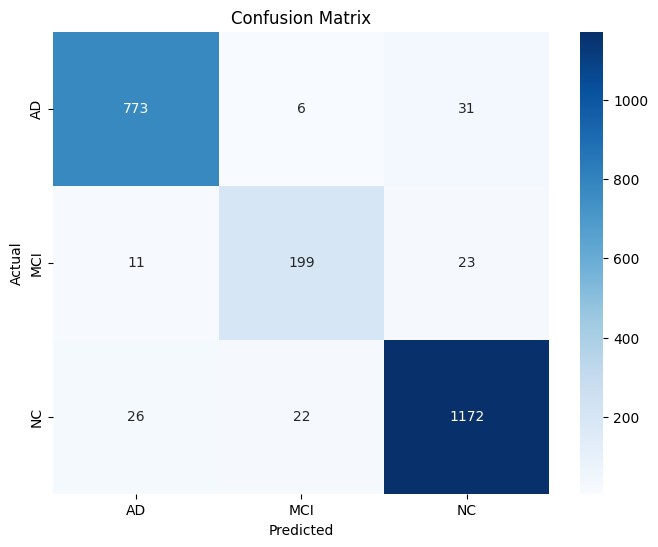

In [46]:
#Now let's show the confusion matrix.
cm = confusion_matrix(y_test, y_pred_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'MCI', 'NC'], yticklabels=['AD', 'MCI', 'NC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#Comments: 98% accuracy of Alzheimer’s Disease detection (That's exactly what we want, we prefered to detect the person who have disease 98% accuracy over than detect normal person 95% accuracy).
#Let's try other models as RandomForest and CNN"